In [1]:
import sys
sys.path.append("..")  # Adds the parent directory to the sys.path

from hough_circle_trafo import hough_circle
from utitlity_functions import *
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from background_subtraction_gmm import Backsub as Backsub
import scienceplots
import cv2 as cv
from matplotlib import cm
from segmentation import Segmentation as Segmentation
from PIL import Image, ImageDraw
import networkx as nx
from networkx.algorithms import bipartite
np.random.seed(137)

# Example of plot

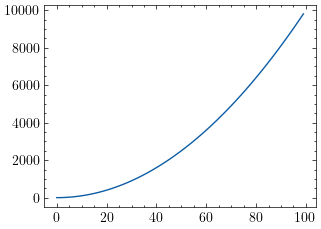

In [2]:
plt.style.use('science')
x=np.arange(100)
y=x**2
with plt.style.context('science'):
    plt.figure()
    plt.plot(x, y)
    plt.show()

# Load Images

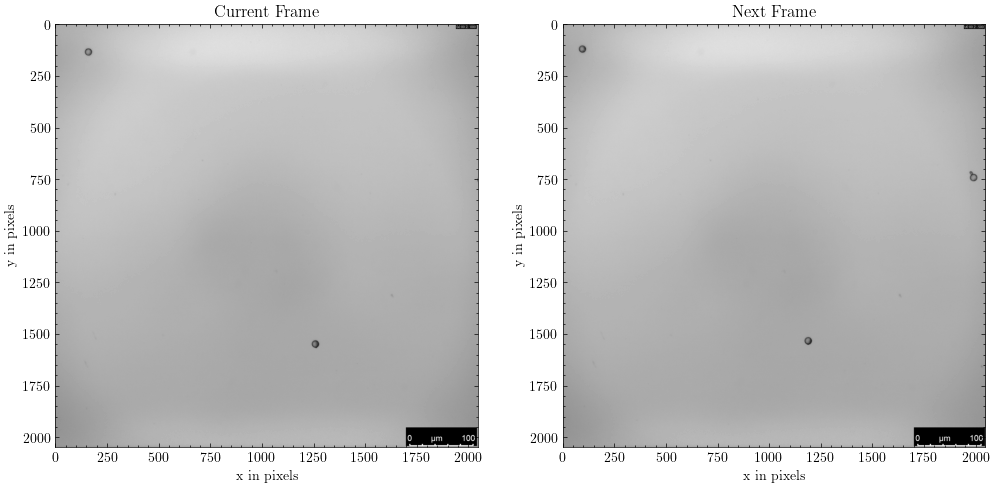

In [3]:
start_frame=0
end_frame=999
stream_string=[]
for i in range(start_frame,end_frame+1):
    im_path="/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/Image_Data/Aufnahmen_JPEG_06_07_take_2/Hoang_07_06_2023_Aufnahmen_Rollen_Partikel_Rollen_12_mu_200_002_t"+str(i).zfill(3)+".jpg"
    stream_string.append(im_path)


current_frame_number=220
next_frame_number=235

current_frame=cv.imread(stream_string[current_frame_number], cv.IMREAD_GRAYSCALE)
next_frame=cv.imread(stream_string[next_frame_number], cv.IMREAD_GRAYSCALE)
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [12, 12]
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.set_title('Current Frame')
    ax1.imshow(current_frame, cmap="gray")
    ax1.set_xlabel("x in pixels")
    ax1.set_ylabel("y in pixels")
    ax2.set_title('Next Frame')
    ax2.imshow(next_frame, cmap="gray")
    ax2.set_xlabel("x in pixels")
    ax2.set_ylabel("y in pixels")
    plt.show()

# After Segmentation

In [4]:
backsub=Backsub("../Video_Data/take_02.avi",history=100)
number_training_images=250
backsub.begin_train(max_frames=number_training_images)
segm=Segmentation(backsub)
current_frame_bgr=cv.cvtColor(current_frame, cv.COLOR_GRAY2BGR)
next_frame_bgr=cv.cvtColor(next_frame, cv.COLOR_GRAY2BGR)
circles_current=segm.segment_image(current_frame_bgr)
circles_next=segm.segment_image(next_frame_bgr)


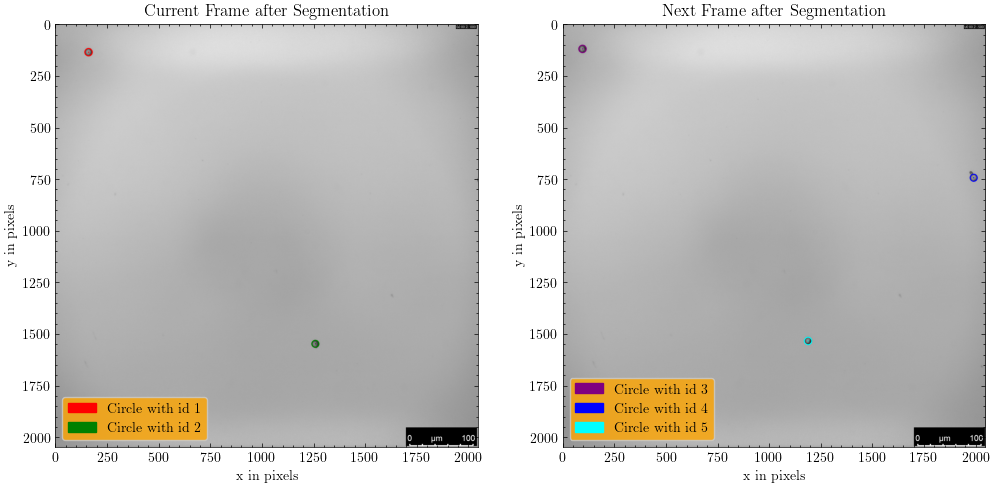

In [5]:
colors_current=[(255, 0, 0), (0, 128, 0)]
colors_next=[(128, 0, 128), (0,0,255), (0,255,255)]

for i,circle_current in enumerate(circles_current):
    center = (round(circle_current[0]), round(circle_current[1]))
    # circle outline
    radius = round(circle_current[2])
    # circle center
    cv.circle(current_frame_bgr, center, 1, colors_current[i], 3)
    cv.circle(current_frame_bgr, center, radius, colors_current[i], 3)
for i,circle_next in enumerate(circles_next):
    center = (round(circle_next[0]), round(circle_next[1]))
    # circle outline
    radius = round(circle_next[2])
    # circle center
    cv.circle(next_frame_bgr, center, 1, colors_next[i], 3)
    cv.circle(next_frame_bgr, center, radius, colors_next[i], 3)

with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [12, 12]
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.set_title('Current Frame after Segmentation')
    ax1.imshow(current_frame_bgr)
    ax1.set_xlabel("x in pixels")
    ax1.set_ylabel("y in pixels")
    ax2.set_title('Next Frame after Segmentation')
    ax2.imshow(next_frame_bgr)
    ax2.set_xlabel("x in pixels")
    ax2.set_ylabel("y in pixels")
    red_patch = mpatches.Patch(color='red', label='Circle with id 1')
    green_patch = mpatches.Patch(color='green', label='Circle with id 2')
    purple_patch = mpatches.Patch(color='purple', label='Circle with id 3')
    blue_patch = mpatches.Patch(color='blue', label='Circle with id 4')
    cyan_patch =  mpatches.Patch(color='cyan', label='Circle with id 5')
    ax1.legend(handles=[red_patch, green_patch],frameon=True, facecolor="orange", loc='lower left')
    ax2.legend(handles=[purple_patch, blue_patch, cyan_patch],frameon=True, facecolor="orange", loc='lower left')
    plt.show()

# Display Frames as Bipartite Graph

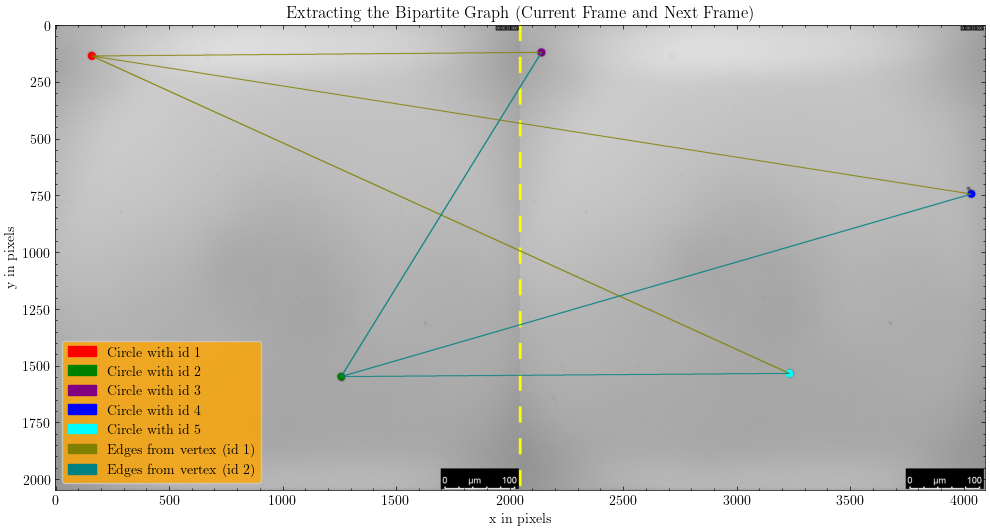

In [6]:
current_frame_rgb=cv.cvtColor(current_frame,cv.COLOR_GRAY2RGB)
next_frame_rgb=cv.cvtColor(next_frame,cv.COLOR_GRAY2RGB)

colors_current=[(255, 0, 0), (0, 128, 0)]
colors_next=[(128, 0, 128), (0,0,255), (0,255,255)]

for i,circle_current in enumerate(circles_current):
    center = (round(circle_current[0]), round(circle_current[1]))
    # circle outline
    radius = round(circle_current[2])
    # circle center
    cv.circle(current_frame_rgb, center, 1, colors_current[i], -1)
    cv.circle(current_frame_rgb, center, radius, colors_current[i], -1)
for i,circle_next in enumerate(circles_next):
    center = (round(circle_next[0]), round(circle_next[1]))
    # circle outline
    radius = round(circle_next[2])
    # circle center
    cv.circle(next_frame_rgb, center, 1, colors_next[i], -1)
    cv.circle(next_frame_rgb, center, radius, colors_next[i], -1)
resize_length=500

Im_left=Image.fromarray(current_frame_rgb, mode='RGB')
Im_right=Image.fromarray(next_frame_rgb, mode='RGB')


# Create a blank canvas for the illustration
illustration_width = Im_left.width+Im_right.width 
illustration_height = max(Im_left.height, Im_right.height)  # Adjust as needed
illustration = Image.new("RGB", (illustration_width, illustration_height), "white")

# Paste the both images on the canvas
illustration.paste(Im_left, (0, 0))  
illustration.paste(Im_right, (Im_left.width, 0))  

draw = ImageDraw.Draw(illustration)

step_length=70
for i in np.arange(0,Im_left.height,2*step_length):
    draw.line(
        [(Im_left.width, i), (Im_left.width,i+step_length)],
        fill="yellow",
        width=12,
    )

X=np.zeros(5,dtype=int)
Y=np.zeros(5,dtype=int)
X[:2]=np.round(circles_current[:,0]).astype(int)
X[2:]=np.round(circles_next[:,0]).astype(int)
Y[:2]=np.round(circles_current[:,1]).astype(int)
Y[2:]=np.round(circles_next[:,1]).astype(int)

draw.line(
        [(X[0], Y[0]), (X[2]+Im_left.width,Y[2])],
        fill="olive",
        width=5,
    )
draw.line(
        [(X[0], Y[0]), (X[3]+Im_left.width,Y[3])],
        fill="olive",
        width=5,
    )
draw.line(
        [(X[0], Y[0]), (X[4]+Im_left.width,Y[4])],
        fill="olive",
        width=5,
    )
draw.line(
        [(X[1], Y[1]), (X[2]+Im_left.width,Y[2])],
        fill="teal",
        width=5,
    )
draw.line(
        [(X[1], Y[1]), (X[3]+Im_left.width,Y[3])],
        fill="teal",
        width=5,
    )
draw.line(
        [(X[1], Y[1]), (X[4]+Im_left.width,Y[4])],
        fill="teal",
        width=5,
    )




with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [12, 12]
    ax=plt.figure()
    plt.title("Extracting the Bipartite Graph (Current Frame and Next Frame)")
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    plt.imshow(illustration,cmap="gray")
    olive_patch =  mpatches.Patch(color='olive', label='Edges from vertex (id 1)')
    teal_patch =  mpatches.Patch(color='teal', label='Edges from vertex (id 2)')
    plt.legend(handles=[red_patch, green_patch,purple_patch, blue_patch, cyan_patch, olive_patch, teal_patch],frameon=True, facecolor="orange", loc='lower left')
    plt.show()

# Draw Bipartite Graph

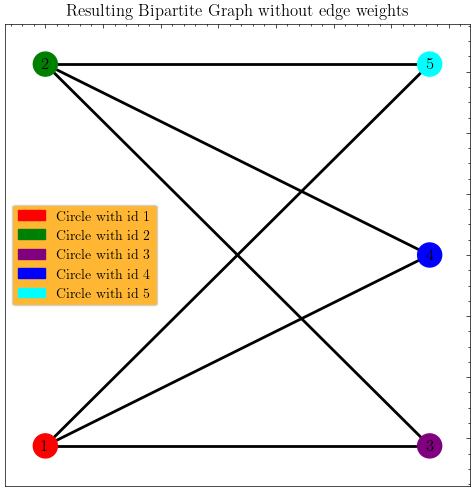

In [7]:
G = nx.Graph()
G.add_nodes_from([1,2], bipartite=0)
G.add_nodes_from([3,4,5],bipartite=1)
colormap=["red", "green", "purple", "blue", "cyan"]
for i in range(1,3):
    for j in range(3,6):
        G.add_edges_from([(i,j)])
pos=nx.drawing.layout.bipartite_layout(G, [1,2])
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [6, 6]
    ax=plt.figure()
    plt.title("Resulting Bipartite Graph without edge weights")
    nx.draw_networkx(G, pos=pos, node_color=colormap,width=2)
    olive_patch =  mpatches.Patch(color='olive', label='Edges from vertex (id 1)')
    teal_patch =  mpatches.Patch(color='teal', label='Edges from vertex (id 2)')
    plt.legend(handles=[red_patch, green_patch,purple_patch, blue_patch, cyan_patch],frameon=True, facecolor="orange")
    plt.show()


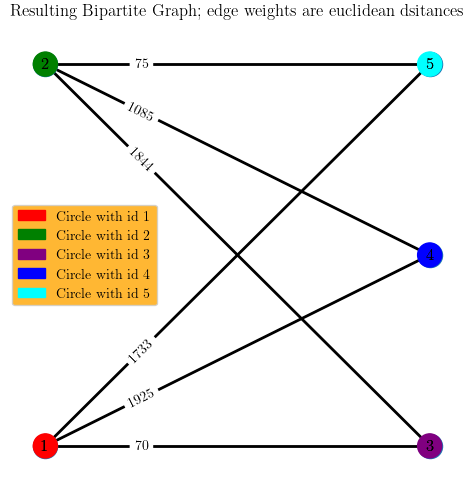

In [8]:
G = nx.Graph()
G.add_nodes_from([1,2], bipartite=0)
G.add_nodes_from([3,4,5],bipartite=1)
colormap=["red", "green", "purple", "blue", "cyan"]
for i in range(1,3):
    for j in range(3,6):
        weight=np.sqrt((X[i-1]-X[j-1])**2 + (Y[i-1]-Y[j-1])**2)
        G.add_edge(i, j, weight=round(weight))

pos=nx.drawing.layout.bipartite_layout(G, [1,2])
weights = nx.get_edge_attributes(G,'weight')
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [6, 6]
    ax=plt.figure()
    plt.title("Resulting Bipartite Graph; edge weights are euclidean dsitances")
    nx.draw(G,pos, with_labels=True)
    nx.draw_networkx(G, pos=pos, node_color=colormap,width=2)
    nx.draw_networkx_edge_labels(G,pos=pos, edge_labels=weights, label_pos=0.75)
    olive_patch =  mpatches.Patch(color='olive', label='Edges from vertex (id 1)')
    teal_patch =  mpatches.Patch(color='teal', label='Edges from vertex (id 2)')
    plt.legend(handles=[red_patch, green_patch,purple_patch, blue_patch, cyan_patch],frameon=True, facecolor="orange")
    plt.show()

